# CA683 Assignment - Group 25
## Predict Arteial Blood Pressure (ABP) Signal from photoplethysmography (PPG) Signal. The prediction is implemented through deep learning model.


## Mounting Google Drive to load the required files

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Libraries

In [4]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import warnings
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras import optimizers
from scipy import signal
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

## Providing Datapath of the mat files obtained from UCI. It consists of 8 mat files (3 X 63000)

In [5]:
datapath = '/content/drive/MyDrive/Dataset/'

## Defining Functions to load full and partial list of mat files

In [6]:
def load_data_partial(filename):
  mat_contents = sio.loadmat(filename)

  return mat_contents

In [7]:
def load_data(fileDir, exercise):
    word = exercise.lower()
    file_path_list = []
    valid_file_extensions = [".mat"]
    valid_file_extensions = [item.lower() for item in valid_file_extensions]


    for file in os.listdir(fileDir):
        extension = os.path.splitext(file)[1]
        if extension.lower() not in valid_file_extensions:
            continue
        file_path_list.append(os.path.join(fileDir, file))

    Data = []
    for path in file_path_list:
        base=os.path.basename(path)
        base = os.path.splitext(base)[0]
        if word in base:
            print(fileDir+'/%s'%(base))
            mat_contents = sio.loadmat(fileDir+'/%s'%(base))
            val = mat_contents['p']
            total_array = val[0,:] #assigning an array
            Data.append(total_array)

    return Data

### Loading the MAT files

In [8]:
word = 'part'
total_data = load_data(datapath, word)
x =load_data_partial(datapath+str('part_1.mat'))

/content/drive/MyDrive/Dataset//part_1
/content/drive/MyDrive/Dataset//part_10
/content/drive/MyDrive/Dataset//part_11
/content/drive/MyDrive/Dataset//part_12
/content/drive/MyDrive/Dataset//part_2
/content/drive/MyDrive/Dataset//part_3
/content/drive/MyDrive/Dataset//part_4
/content/drive/MyDrive/Dataset//part_5
/content/drive/MyDrive/Dataset//part_6
/content/drive/MyDrive/Dataset//part_7
/content/drive/MyDrive/Dataset//part_8
/content/drive/MyDrive/Dataset//part_9


In [9]:
x.keys()


dict_keys(['__header__', '__version__', '__globals__', 'p'])

[link text](https://)### Plotting the ABP signal for 1000 samples (normalized values and scaled back values)

(3, 61000)


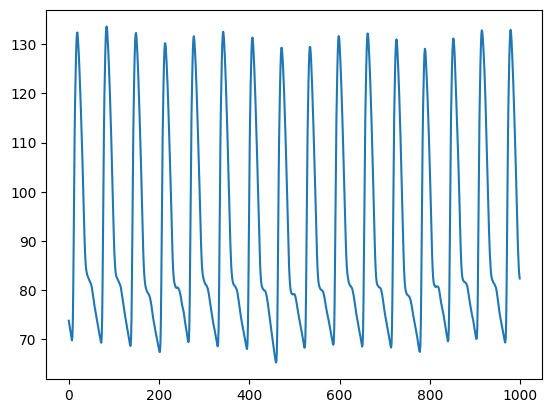

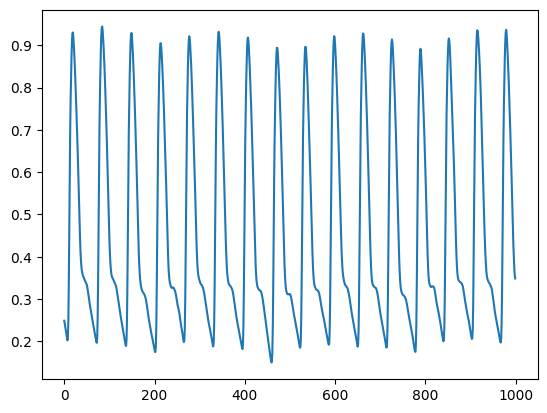

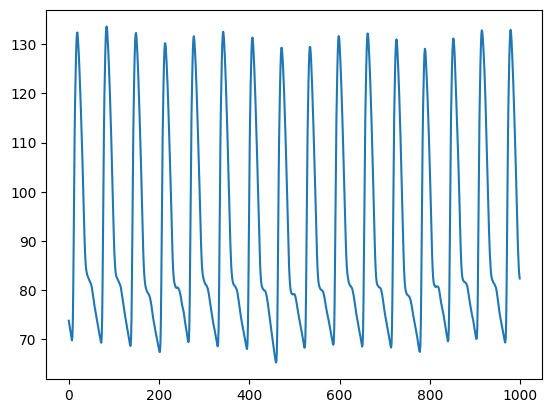

In [10]:
abp_list = x['p'][0,1]
print(abp_list.shape)
abp = x['p'][0,1][1,:1000]


x_max = max(abp_list[1,:])
x_min = min(abp_list[1,:])


plt.figure()
plt.plot(abp)

nrm_abp = (abp-x_min)/(x_max-x_min)  # Normalizing Data between 0 and 1
plt.figure()
plt.plot(nrm_abp)


ret_abp = nrm_abp*(x_max - x_min) +x_min   #Reversed from normalized value
plt.figure()
plt.plot(ret_abp)

## Setting the configuration parameters for the models

In [36]:
config = {
    'seed': 77,
    'sample_size': 2000,
    'train_size': 3000000, # train on 3 million data points
    'train_params':{
        'batch_size':139,
        'epochs': 75,
        'learn_rate': 0.003,#1e-3,
    }
}

In [12]:
# Initializing TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# Instantiate distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

auto = tf.data.experimental.AUTOTUNE
replicas = tpu_strategy.num_replicas_in_sync
Batch_size = config['train_params']['batch_size'] * replicas
print(f'Number of Replicas: {replicas}')

Number of Replicas: 8


In [13]:
def SetSeed(seed=None):
    """Set seed for reproducibility."""
    tf.random.set_seed(seed)
    np.random.seed(seed)

SetSeed(seed=config['seed'])

In [ ]:
print(len(total_data))
print(len(total_data[1]))
print(total_data[1][1].shape)

12
1000
(3, 6000)


In [ ]:
print(total_data[0][1])

[[ 2.40957967  2.32942326  2.23851417 ...  1.24046921  1.23069404
   1.21994135]
 [73.75459745 73.1684682  72.53349484 ... 99.15353167 96.22288542
  93.19455095]
 [ 0.18475073  0.17986315  0.16959922 ...  0.29472141  0.31964809
   0.33968719]]


## Defining Function to Normalize the PPG and ABP values

In [14]:
def normalise(x):
  normalised = (x-min(x))/(max(x)-min(x))
  return normalised

def scale_abp(x):
  normalised = x/200
  return normalised

def normalise_abp(abp, x_max, x_min):
  normalised = (abp-x_min)/(x_max-x_min)
  return normalised

def abp_maxmin_value(x):
  max_x = []
  min_x = []
  for i in range(len(x)):
    for j in range(len(x[i])):
      max_x.append(max(x[i][j][1,:]))
      min_x.append(min(x[i][j][1,:]))
  x_max = max(max_x)
  x_min = min(min_x)

  return x_max, x_min

### Checking Minimum and Maximum values in total_data

In [15]:
x_max, x_min = abp_maxmin_value(total_data)
print(x_max, x_min)
x_max = 200.0
x_min = 50.0

199.98749589709124 50.0


## Feature Extraction and Feature Scaling: Extracting PPG ,ECG and ABP values from total_data and normalizing them

In [16]:
# #Data Pre-processing
# # Extracting signal data Feature-extraction
PPG_N = []
ABP_N = []
ECG_N = []
i=0
for j in range(len(total_data[i])):
  k = len(total_data[i][j][0,:])
  for n in range(k//1000):
      ppg_n = normalise(total_data[i][j][0,(n*1000):(n*1000)+1000])
      abp_n = normalise_abp(total_data[i][j][1,(n*1000):(n*1000)+1000], x_max, x_min)
      ecg_n = normalise(total_data[i][j][2,(n*1000):(n*1000)+1000])
      PPG_N.append(ppg_n)
      ABP_N.append(abp_n)
      ECG_N.append(ecg_n)


PPG_N = np.asarray(PPG_N)
ABP_N = np.asarray(ABP_N)
ECG_N = np.asarray(ECG_N)


In [ ]:
PPG_N

array([[0.37122302, 0.35107914, 0.33429257, ..., 0.10071942, 0.09304556,
        0.0853717 ],
       [0.11562058, 0.10854176, 0.10146295, ..., 0.80887211, 0.76970269,
        0.73006135],
       [0.66329966, 0.61375661, 0.56373256, ..., 0.12409812, 0.11784512,
        0.11063011],
       ...,
       [0.92398489, 0.93767705, 0.94098206, ..., 0.47780925, 0.43909348,
        0.40084986],
       [0.09041096, 0.08675799, 0.08219178, ..., 0.01917808, 0.01826484,
        0.01780822],
       [0.84704112, 0.84854564, 0.84503511, ..., 0.16399198, 0.15496489,
        0.14694082]])

In [ ]:
PPG_N.shape

(32061, 1000)

In [ ]:
len(PPG_N)

32061

### Plotting graphs for Normalized PPG,ECG and ABP signals

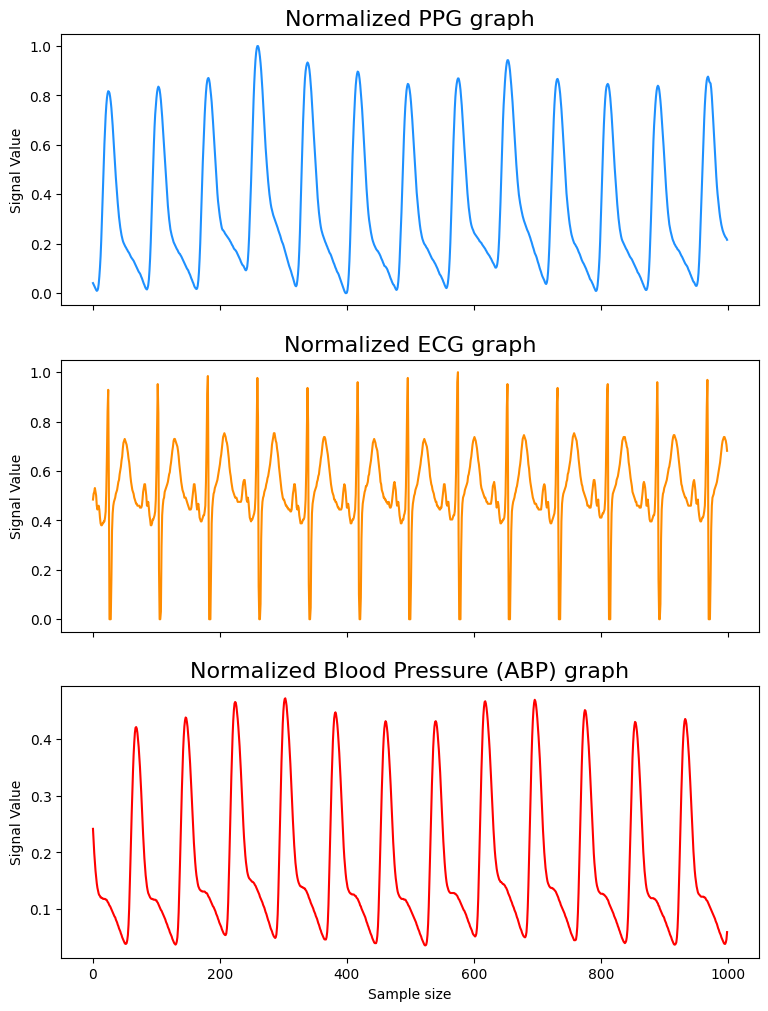

In [17]:
# ##plotting sample normalized ppg, ecg and bp signals
# ##using a sample size of 125
fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)
y = 1000
ax[0].set_title('Normalized PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(PPG_N[y,:], c = 'dodgerblue')

ax[1].set_title('Normalized ECG graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(ECG_N[y,:], c='darkorange')

ax[2].set_title('Normalized Blood Pressure (ABP) graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(ABP_N[y,:], c = 'red')

## Splitting the normalized data into 70% train and 30% test
**Input** : *Normalized PPG values*

**Output**: *Normalized ABP values*

In [18]:
# creating train and val sets
X_train, X_test, y_train, y_test = train_test_split(PPG_N, ABP_N, test_size=0.30)

In [ ]:
X_train

array([[0.31236443, 0.37700651, 0.44251627, ..., 0.1483731 , 0.14013015,
        0.1318872 ],
       [0.88481906, 0.87422771, 0.85834069, ..., 0.01897617, 0.01853486,
        0.01765225],
       [0.41283974, 0.40018744, 0.38800375, ..., 0.35379569, 0.42783505,
        0.50140581],
       ...,
       [0.3770712 , 0.34572324, 0.31168831, ..., 0.16972682, 0.16524854,
        0.16121809],
       [0.06055129, 0.05964754, 0.05874379, ..., 0.45503841, 0.53185721,
        0.60641663],
       [0.23945578, 0.23174603, 0.22358277, ..., 0.26893424, 0.3170068 ,
        0.37278912]])

In [ ]:
X_train.shape

(22442, 1000)

In [ ]:
y_train

array([[0.28757231, 0.28210178, 0.27897576, ..., 0.06953245, 0.06836019,
        0.06640643],
       [0.18558592, 0.17972464, 0.17464485, ..., 0.52046078, 0.51733476,
        0.51342723],
       [0.06445266, 0.06288965, 0.06132664, ..., 0.20903107, 0.20864032,
        0.20981258],
       ...,
       [0.091936  , 0.09128475, 0.08542345, ..., 0.36937051, 0.34950724,
        0.32834147],
       [0.63573275, 0.63026221, 0.62322867, ..., 0.26686243, 0.26529942,
        0.26373641],
       [0.19691774, 0.19496398, 0.19222872, ..., 0.55445624, 0.53062034,
        0.51342723]])

## LSTM Model

### Reshaping the X_train and X_test values for LSTM model
The input to a LSTM model should be 3D(Sample Size, Time Step and Number of Features). Hence reshaping X_train and X_test to match the required input dimension.

In [19]:
X_train_reshape = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [26]:
X_train_reshape.shape

(22442, 1000, 1)

In [27]:
X_train_reshape

array([[[0.31236443],
        [0.37700651],
        [0.44251627],
        ...,
        [0.1483731 ],
        [0.14013015],
        [0.1318872 ]],

       [[0.88481906],
        [0.87422771],
        [0.85834069],
        ...,
        [0.01897617],
        [0.01853486],
        [0.01765225]],

       [[0.41283974],
        [0.40018744],
        [0.38800375],
        ...,
        [0.35379569],
        [0.42783505],
        [0.50140581]],

       ...,

       [[0.3770712 ],
        [0.34572324],
        [0.31168831],
        ...,
        [0.16972682],
        [0.16524854],
        [0.16121809]],

       [[0.06055129],
        [0.05964754],
        [0.05874379],
        ...,
        [0.45503841],
        [0.53185721],
        [0.60641663]],

       [[0.23945578],
        [0.23174603],
        [0.22358277],
        ...,
        [0.26893424],
        [0.3170068 ],
        [0.37278912]]])

In [20]:
X_test_reshape =np.reshape(X_test,(X_test.shape[0] ,X_test.shape[1],1))

In [29]:
X_test_reshape.shape

(9619, 1000, 1)

In [30]:
X_test_reshape

array([[[0.01354303],
        [0.01266929],
        [0.01485365],
        ...,
        [0.76933159],
        [0.78331149],
        [0.79554391]],

       [[0.47955846],
        [0.47751431],
        [0.47587899],
        ...,
        [0.48037612],
        [0.46034342],
        [0.4415372 ]],

       [[0.01683502],
        [0.01539202],
        [0.01443001],
        ...,
        [0.2967773 ],
        [0.37518038],
        [0.45791246]],

       ...,

       [[0.33274648],
        [0.3243838 ],
        [0.31778169],
        ...,
        [0.53785211],
        [0.49427817],
        [0.44674296]],

       [[0.0367713 ],
        [0.03542601],
        [0.03408072],
        ...,
        [0.69686099],
        [0.66502242],
        [0.63004484]],

       [[0.54580645],
        [0.53849462],
        [0.52989247],
        ...,
        [0.54580645],
        [0.5372043 ],
        [0.52989247]]])

In [21]:
from keras import backend as K
from keras import Model as md
from keras import regularizers
K.clear_session()
def LSTM_Model(input_dim, num_class):
    model = Sequential()
    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(input_dim.shape[1], input_dim.shape[2])))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(32, return_sequences=False))
    model.add(layers.Dense(num_class))
    return model


In [22]:
Input_dim= X_train_reshape
Classes = 1000

# # Creating the model on TPU
with tpu_strategy.scope():
  model = LSTM_Model(input_dim=Input_dim,num_class=Classes)
  model.compile(loss='mse',optimizer='adam',metrics=[tf.keras.metrics.RootMeanSquaredError()])
  from keras.callbacks import ModelCheckpoint, EarlyStopping
  es = EarlyStopping(monitor='val_loss',patience=20, min_delta=1e-3,mode='auto')
  model.summary()
  #tf.keras.optimizers.SGD(lr=config['train_params']['learn_rate'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1000, 128)        33792     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 1000, 64)          49408     
                                                                 
 lstm_2 (LSTM)               (None, 1000, 64)          33024     
                                                                 
 lstm_3 (LSTM)               (None, 1000, 64)          33024     
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1000)              33000     
                                                        

In [35]:
from tensorflow.keras import layers, models

# Step 1: Define the Autoencoder Model
def Autoencoder(input_dim):
    # Encoder
    encoder_input = layers.Input(shape=input_dim)
    encoded = layers.Dense(64, activation='relu')(encoder_input)  # Adjust the number of units as needed
    encoder_output = layers.Dense(32, activation='relu')(encoded)  # Adjust the number of units as needed

    # Decoder
    decoded = layers.Dense(64, activation='relu')(encoder_output)  # Adjust the number of units as needed
    decoder_output = layers.Dense(input_dim, activation='linear')(decoded)

    autoencoder = models.Model(inputs=encoder_input, outputs=decoder_output)
    autoencoder.compile(optimizer='adam', loss='mse')  # You can use a different loss function if needed

    return autoencoder

# Step 2: Pretrain the Autoencoder
autoencoder = Autoencoder(input_dim=X_train_reshape.shape[1])
autoencoder.summary()
pretrain_epochs = 75  # Set the number of epochs for pretraining the autoencoder
autoencoder.fit(X_train_reshape, X_train_reshape, epochs=pretrain_epochs, batch_size=Batch_size, verbose=1)

# Step 3: Use the Encoder as Input to the LSTM Model
encoder_model = models.Model(inputs=autoencoder.input, outputs=autoencoder.layers[-3].output)  # Get the encoder part
encoder_output = encoder_model.predict(X_train_reshape)

# Combine with LSTM Model
with tpu_strategy.scope():
    lstm_model = LSTM_Model(input_dim=encoder_output.shape[1], num_class=Classes)
    lstm_model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    lstm_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_1 (Dense)             (None, 64)                64064     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 1000)              65000     
                                                                 
Total params: 133,256
Trainable params: 133,256
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
72/72 [==============================] - 6s 

### Training the LSTM Model

In [39]:
# Training the LSTM model
LSTM_model_train = model.fit(X_train_reshape[:config['train_size']], # using the first 3 million rows.
                    y_train[:config['train_size']],
                    validation_split=0.1,
                    epochs=config['train_params']['epochs'],
                    batch_size=Batch_size,
                    callbacks=[es],
                    shuffle=False,
                    verbose = 1
                   )

Epoch 1/75
65/65 [==============================] - 81s 1s/step - loss: 0.0199 - root_mean_squared_error: 0.1410 - val_loss: 0.0198 - val_root_mean_squared_error: 0.1407
Epoch 2/75
65/65 [==============================] - 81s 1s/step - loss: 0.0192 - root_mean_squared_error: 0.1387 - val_loss: 0.0194 - val_root_mean_squared_error: 0.1394
Epoch 3/75
65/65 [==============================] - 81s 1s/step - loss: 0.0188 - root_mean_squared_error: 0.1369 - val_loss: 0.0189 - val_root_mean_squared_error: 0.1375
Epoch 4/75
65/65 [==============================] - 81s 1s/step - loss: 0.0185 - root_mean_squared_error: 0.1358 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1372
Epoch 5/75
65/65 [==============================] - 81s 1s/step - loss: 0.0180 - root_mean_squared_error: 0.1340 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1387
Epoch 6/75
65/65 [==============================] - 81s 1s/step - loss: 0.0177 - root_mean_squared_error: 0.1329 - val_loss: 0.0177 - val_root_mean_sq

### Prediction of BP values from normalized PPG values from test set - LSTM

In [40]:
from keras.models import load_model
import numpy as np
import tensorflow as tf

# Load the saved model
loaded_model = load_model('/content/drive/MyDrive/model_best1.h5')

# Assuming you have X_test_reshape and y_test available

# Predict using the loaded model
LSTM_predictions = loaded_model.predict(X_test_reshape[:config['train_size']])

# Calculate RMSE
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(y_test[:config['train_size']], LSTM_predictions)
print(f'LSTM Model RMSE: {rmse.result().numpy()}')

301/301 [==============================] - 101s 327ms/step
LSTM Model RMSE: 0.10724903643131256


In [ ]:
len(LSTM_predictions)

In [ ]:
type(LSTM_predictions)

In [ ]:
LSTM_predictions.shape

In [ ]:
LSTM_predictions

In [50]:
y_test

array([[0.50027271, 0.48203758, 0.46022055, ..., 0.27493858, 0.26712352,
        0.25963409],
       [0.3537404 , 0.32769021, 0.30229128, ..., 0.13296505, 0.13101128,
        0.1300344 ],
       [0.62127491, 0.61619513, 0.60994309, ..., 0.31375273, 0.3098452 ,
        0.3016394 ],
       ...,
       [0.20746806, 0.2062958 , 0.20473279, ..., 0.28171103, 0.27545899,
        0.2695977 ],
       [0.49662488, 0.48294854, 0.47005371, ..., 0.15745175, 0.15627949,
        0.15588874],
       [0.26529942, 0.26764394, 0.27194222, ..., 0.29187059, 0.29382435,
        0.30046714]])

In [41]:
# MAE for LSTM Model
MAE= tf.keras.metrics.MeanAbsoluteError()
MAE.update_state(y_test, LSTM_predictions)
print(f'LSTM Model MAE: {MAE.result().numpy()}')

LSTM Model MAE: 0.07881135493516922


In [51]:
# To check if there are no NaN values in LSTM_predictions and y_test
print(len(y_test))
print(len(LSTM_predictions))

print(np.isnan(y_test).any())
print(np.isnan(LSTM_predictions).any())

print(np.argwhere(np.isnan(y_test)))


9619
9619
False
False
[]


In [42]:
#Scaling back y_test and LSTM_predictions to original values to calculate Mean Arterial Pressure (MAP) Error for ANN model
y_tlstm_sb = y_test*(x_max - x_min) +x_min
LSTM_pred_sb = LSTM_predictions*(x_max - x_min) +x_min

In [ ]:
x_max

In [ ]:
x_min

In [ ]:
y_tlstm_sb

In [ ]:
LSTM_pred_sb

In [43]:
#Checking MAP error for LSTM model
score = []
for i in range(len(y_tlstm_sb)):
  score.append(abs(y_tlstm_sb[i]-LSTM_pred_sb[i]))

print("Average MAP error of LSTM model is: %f mmHG" %(np.mean(score)))
print("Standard Deviation of LSTM Model is: %f mmHG" %(np.std(score)))

Average MAP error of LSTM model is: 11.821703 mmHG
Standard Deviation of LSTM Model is: 10.911019 mmHG


### Plotting graph for Train Loss vs RMSE using LSTM model
(with Normalized PPG and BP values)

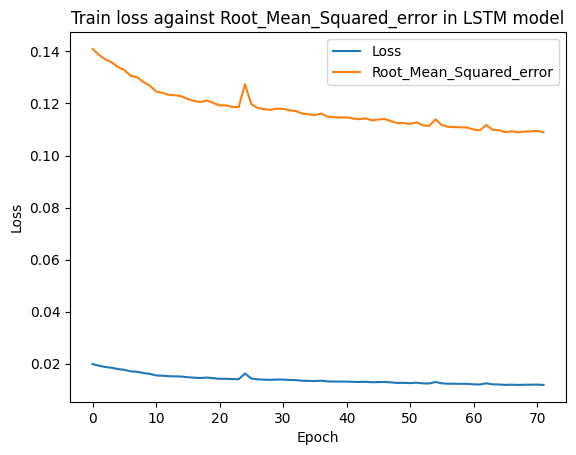

In [44]:
#Visualizing LSTM model Train Loss vs RMSE in LSTM model
plt.title('Train loss against Root_Mean_Squared_error in LSTM model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(LSTM_model_train.history['loss'])
plt.plot(LSTM_model_train.history['root_mean_squared_error'])
plt.legend(['Loss', 'Root_Mean_Squared_error'])

### Plotting graph for True vs Predicted BP values using LSTM

---

Model

---


(with Normalized PPG and BP values)

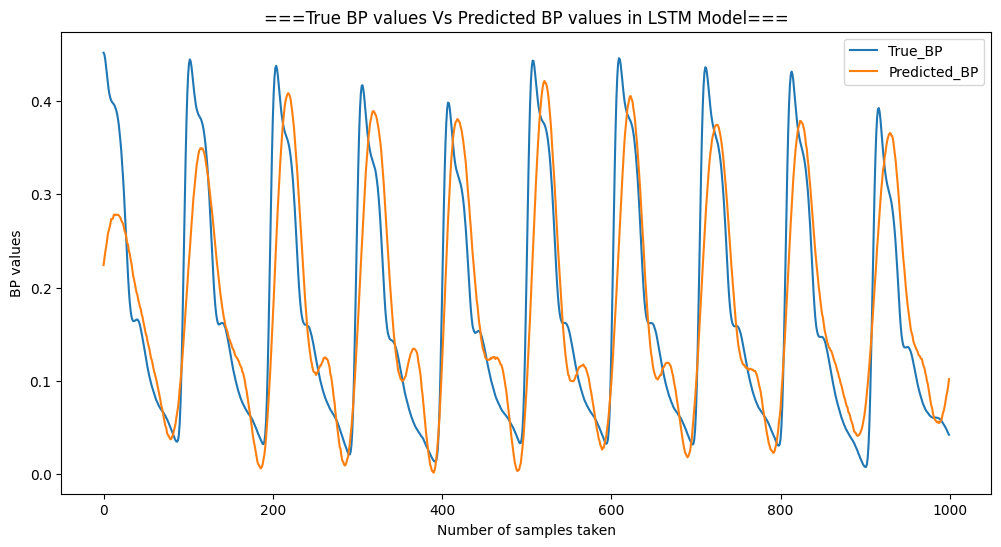

In [45]:
plt.figure(figsize=(12, 6))  # Adjust the width and height as per your preference
plt.title("===True BP values Vs Predicted BP values in LSTM Model===")
plt.xlabel('Number of samples taken')
plt.ylabel('BP values')
plt.plot(y_test[1000, :])  # Only plotting 100 samples
plt.plot(LSTM_predictions[1000, :])
plt.legend(['True_BP', 'Predicted_BP'])
plt.show()
